# Supervised Learning Model Evaluation


**Lesson Goals**

    Explain the importance of a training-test split of your data and how this relates to model 
    overfitting.
    
    Explain what cross-validation is and why it is important.
    
    Calculate several different types of evaluation metrics for a regression model and discuss the 
    pros & cons of each.
    
    Calculate several types of evaluation metrics for a classification model and discuss the 
    pros & cons of each.
    
    Perform basic classifier model diagnostics based on examples.

**Introduction**

One of the most important parts of building a machine learning pipeline is evaluating the quality of the models we create. For a supervised learning problem, this boils down to quantifying an answer to the question: How well does this model describe the underlying process that created my data?

Often there is more than one right answer to this question, and sometimes different answers will be contradictory. In this lesson, we will walk through some of the ways we can go about answering this question and when each approach may or may not be appropriate.


**Splitting Your Data**

When training a model, it is generally helpful to give it as much data as possible; companies will literally spend millions of dollars just to acquire more data to increase the accuracy of their models. Because of this, it is fair to assume that when you go to train a machine learning model, you would want to give the model access to your entire dataset to train on. However, this can lead to some unexpected problems. Consider the following simple example:

In [2]:
!pip install matplotlib

     |████████████████████████████████| 13.1MB 154kB/s eta 0:00:01
     |████████████████████████████████| 92kB 2.1MB/s eta 0:00:01
     |████████████████████████████████| 71kB 2.2MB/s eta 0:00:01


In [3]:
import numpy as np
import matplotlib.pyplot as plt

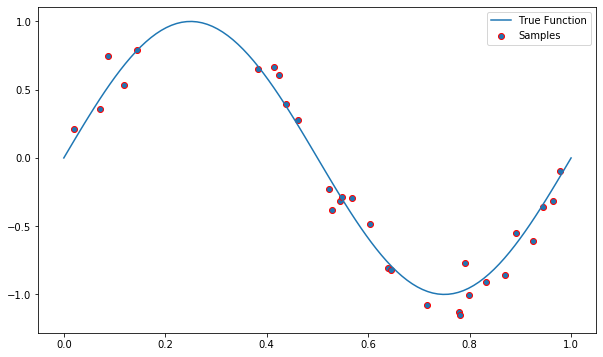

In [4]:
def true_fxn(x):
    """Sine wave function"""
    return np.sin(2 * np.pi * x)

np.random.seed(0)

# Generate random points centered around the true function with a bit of random noise added
num_samples = 30
noise_strength = 0.1
X = np.sort(np.random.rand(num_samples))
y = true_fxn(X) + np.random.randn(num_samples) * noise_strength

plt.figure(figsize=(10, 6))
X_range = np.linspace(0, 1, 100)
plt.plot(X_range, true_fxn(X_range), label="True Function")
plt.scatter(X, y, label="Samples", edgecolor='r')
plt.legend(loc="best")
plt.show();

In this example, we define a true function (a sine wave), then sample it at 30 points, with a bit of random noise added at each point. In a machine learning problem, our goal might be to train a regression model to predict the sample value (y) based on any input (x). We want to use a high-powered, descriptive model, so let's try to train a high-order model on this dataset. After all, it has a lot of different parameters, so it must be able to fit the data well! Here we'll use Scikit-learn to train a linear model based on polynomial regression.

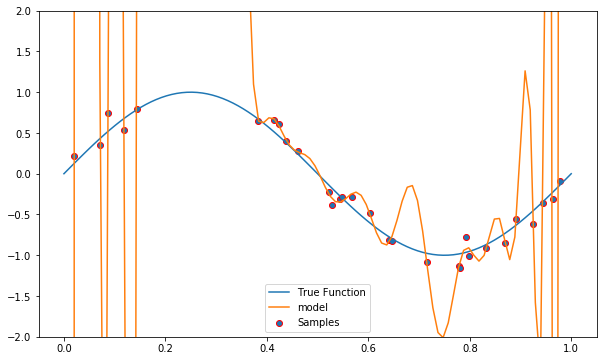

In [6]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(degree=40), LinearRegression())
model.fit(X[:, np.newaxis], y)

plt.figure(figsize=(10, 6))
X_range = np.linspace(0, 1, 100)
plt.plot(X_range, true_fxn(X_range), label="True Function")
plt.plot(X_range, model.predict(X_range[:, np.newaxis]), label="model")
plt.scatter(X, y, label="Samples", edgecolor='r')
plt.legend(loc="best")
plt.ylim((-2, 2))
plt.show();

Looking at this plot, we can quickly see that this is a terrible model. It is wildly unstable, and sampling from it in most places along this range would result in values far away from the true function (blue line). However, when we score this model using Scikit-learn's built-in score method, it looks like a great model! 

In [7]:
model.score(X[:, np.newaxis], y)

0.9956437450685929

Is Scikit-learn's score function broken? Lets take another look at the plot again. The model is a poor representation of the underlying function, but it does pass exactly through virtually every point we sampled. We'll get into exactly how score is calculated shortly, but for now it's enough to know that it takes every training example we give it in x, predicts the output using the trained model, then compares it to the real value, y. In this case, the model gets y almost exactly right for all 30 points in x, so our naive score of the model is very high, despite the model being a poor representation of the true underlying function. Indeed, if we took this model and tried to use it to predict arbitrary values, we would quickly run into trouble. It has done a good job of fitting to the 30 specific points that we sampled to, at the expensive of fidelity to the underlying function. This is a classic example of overfitting.

This was a simple example, but in the real world, we frequently apply extremely powerful, versatile models with hundreds, thousands, or even millions of adjustable parameters to large data sets. These models have extraordinary expressive power, but this same flexibility also makes them very susceptible to overfitting. There are many techniques, under the broad heading of regularization to combat this during model training, but it is extremely important that we constantly watch out for the possibility of overfitting when evaluating models.

One of the easiest, and most common, ways to do this is to separate our data into training and testing sets before we train the model. The model never sees the testing data at any step of the training process, so it never gets a chance to adjust its shape to it. Then, after training the model, we evaluate the model performance not on the training data that it has seen before, but on the testing data. We can split a data set into training and testing sets using Scikit-learn's train_test_split function as follows. 

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.reshape(30, 1), y, test_size=0.3)

In this example, we randomly split off 30% of the data into a testing set and trained the model on the remaining 70%. Now, when we then fit and score the model on both the training set and the testing set, we can see just how poorly this model fits the unseen examples in the testing set.

In [9]:
model.fit(X_train, y_train)

print("Model performance on traing set: {}".format(model.score(X_train, y_train)))
print("Model performance on testing set: {}".format(model.score(X_test, y_test)))

Model performance on traing set: 0.9999999998550851
Model performance on testing set: -676.0467484254792


We can see this visually on the plot below - the model goes through almost all of the green points, but some of the red points are nowhere near the model function. High performance on a training set combined with lower performance on a testing/holdout set is a classic signature of overfitting.

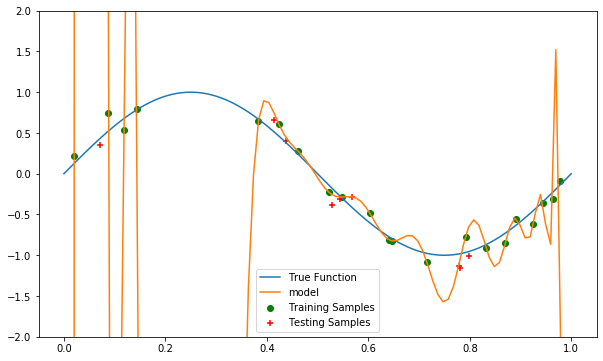

In [10]:
plt.figure(figsize=(10, 6))
X_range = np.linspace(0, 1, 100)
plt.plot(X_range, true_fxn(X_range), label="True Function")
plt.plot(X_range, model.predict(X_range[:, np.newaxis]), label="model")
plt.scatter(X_train, y_train, label="Training Samples", color='g')
plt.scatter(X_test, y_test, label="Testing Samples", color='r', marker="+")
plt.legend(loc="best")
plt.ylim((-2, 2))
plt.show();

A few key points to take away from this example are:

    You should always hold a bit of your data separate when performing machine learning. The exact split 
    can vary, but 25-30% is typical. Holding more than that can risk reducing the amount of training 
    data you have available to you, especially with small datasets.

    Holding out a test set doesn't, by itself, prevent overfitting. It just gives you a tool to 
    recognize overfitting is occurring so that you can take preventative measures.

    For a test set to be useful, it needs to be representative of the overall dataset. You should 
    use statistical tools (min/max, average measures, standard deviation, etc.) and plots to ensure 
    that the training and testing set look more or less the same on aggregate.

    If both the training and the test set share a systematic skew (e.g. both have some inaccuracy 
    with respect to the underlying function), the testing set will not help you realize that the model 
    is picking up this skew. It is important to independently evaluate whether your data 
    accurately represent the underlying process.

    We generally want our models to be as generalizable as possible to data they haven't yet seen. 
    If the testing set is limited to the same range of input values as the training set, it does not 
    tell you much about how generalizable the model is to input values outside that range.

With these caveats in mind, holding out an independent testing set for final model evaluation is one of the most useful and easiest tools for being aware of and evaluating the extent of model overfitting.

# Evaluating Regression Models

One of the major types of supervised learning learning problems is a regression model. This type of problem involves finding a model to predict a real-valued output for a real-valued input. The overfitting example we reviewed earlier is an example of a regression model. There are a few different evaluation metrics that are commonly used to evaluate the performance of regression models. No single metric is necessarily better than another; they each provide a slightly different look at an aspect of model fit and give the modeler information about how well the model does on that particular aspect.


**R-Squared (Coefficient of Determination)**

R-squared is arguably the most commonly used metric in basic linear regression problems (it is the default metric for the score function we saw in the LinearRegression model used in the overfitting example earlier). It ranges from 1.0 (perfect fit to the data) to arbitrarily large negative values (models that fit the data very poorly), but normally ranges between 0.0 and 1.0 for well-behaved, reasonably accurate models. Technically speaking, R-squared is the proportion of the variance in the model predictions that is predictable based on the input values. Practically speaking, it attempts to say how likely future samples are to be predicted accurately by this model, based on the tested values. We can think of it as model explained variation / total variation in a model. 

R-squared is a useful metric because it provides a fairly robust measure of how well the model predicts the response variable. However, there are a some major limitations to be wary of:

    Calculated as defined above, the R-squared value is technically an estimate of the real R-squared 
    value of a model. This estimate is inherently biased toward the points that we use to evaluate it 
    on (this relates to the idea of overfitting presented earlier). We can try to sample our 
    evaluation points to limit this bias, but in non-trivial cases (e.g. when we don't know 
    the true underlying function) it is impossible to truly avoid.

    A "good enough" R-squared value is extremely dependent on the domain and problem. Even a model 
    that produces a "low" value can be a valuable model that gives you some powerful insights about 
    a relatively noisy or hard to predict problem. A model with a "high" value can still be 
    inaccurate in very important ways when used to make real world predictions.

    The way we calculate R-squared above implicitly assumes normally distributed error that is 
    small relative to the variation of the function. However, this is not always the case. The 
    statistical intricacies are well beyond the scope of this lesson, but if you're interested 
    in reading more about some reasons not to use R-squared, 
    check out: https://data.library.virginia.edu/is-r-squared-useless/

In general, R-squared is an easy to understand way of evaluating regression models that does a good job in most simple examples. It can break down with more complicated examples though.

Using Scikit-learn, you can calculate R-squared once you have a set of predictions from your model that you can compare to the actual values as follows.

In [11]:
from sklearn.metrics import r2_score

predictions = model.predict(X_test)

score = r2_score(y_test, predictions)  

In [12]:
score

-676.0467484254792

**Mean Squared Error**

Another commonly used metric is Mean Squared Error (MSE). This is an easy error metric to understand - it simply takes the error between the predicted and actual value, squares it, then takes the average (mean).
MSE is a straightforward metric that allows us to track or compare the relative strength of different models (or iterations of the same model during training). It is not normalized, however, so the raw value isn't necessarily meaningful in the abstract. The MSE of a well-fitting model with generally numerically large values might be much higher than the MSE of poor fitting model with numerically small values.

The squaring of the value means that MSE increases quadratically as examples have large error values. This can be a good behavior for heavily penalizing a relatively uniform model for getting incorrect values. However, it can also mean that a relatively small number of incorrect outlier predictions can have a disproportionately large effect on the value. If occasional large incorrect outliers are less important to the solution than average performance, this may not be the desired behavior.

You can calculate the MSE for a model using Scikit-learn's mean_squared_error function as follows. 

In [13]:
from sklearn.metrics import mean_squared_error

score = mean_squared_error(y_test, predictions)

 Note: Another common variation on MSE is Root Mean Squared Error (RMSE), which simply takes the square root of MSE.


**Mean Absolute Error**

Another similar error metric is Mean Absolute Error (MAE). As the name suggests, it is the average (mean) of the absolute value of the errors between predicted and actual values.

This error metric is similar to MAE, but is less affected by individual large outlier errors. This may be more representative in cases where outliers are not hugely important.

Computationally, absolute values can be more expensive than squaring, meaning that this metric can be less efficient to compute. With many problems this isn't a huge concern, but with many training iterations on large datasets, this can become a concern.

Scikit Learn has a mean_absolute_error function that you can use to calculate this for your models.



In [14]:
from sklearn.metrics import mean_absolute_error

score = mean_absolute_error(y_test, predictions)


# Other Metrics

There are other variations on the metrics described here which may be more appropriate for certain classes of problems. One example is using median instead of mean average functions with either squared or absolute error; this has the effect of being even less sensitive to outliers, which can be desirable in some cases. Another variation is applying a log function instead of using the raw errors. This metric is useful for regression problems with exponential characteristics, since later values would otherwise overwhelm earlier predictions.


**Evaluating Classification Models**

The other major type of supervised learning models is classification models. Classification models attempt to predict which of two or more classes a training example fits into. Because the predictions are not real-valued, on one level this makes error metrics simpler - a prediction is either right or wrong. However, in real world problems, we frequently care more about some types of errors than others, and this leads to a variety of different metrics for different types of problems.


**Accuracy Score**

The simplest classification metric simply calculates the ratio of correct to incorrect predictions. This metric is easy to understand, but can be skewed in the common case where a dataset has many more of one class than another (an unbalanced data set). In this case, the accuracy metric may be heavily dominated by its performance on the more common class, and the metric will not accurately report classifier performance for other any other class(es). An example where this might be very problematic would be a classifier system for a rare type of cancer - for the vast majority of cases, the cancer would not be present, and a classifier might naively predict no cancer for almost all cases. This would yield a high accuracy score, however we would be missing the rare yet very important positive cases that we were attempting to find in the first place.

Scikit Learn has an accuracy_score function you can use to calculate the accuracy of a classification model.



In [15]:
from sklearn.metrics import accuracy_score

actual_values = [2, 0, 2, 2, 0, 1]
predictions = [0, 0, 2, 2, 0, 2]

score = accuracy_score(actual_values, predictions)

In [16]:
score

0.6666666666666666

**Balanced Accuracy Score**

To combat accuracy issues with unbalanced datasets, we can calculate a weighted accuracy.

The easiest and most common weighting scheme is to calculate weights based on the relative proportion of a class in the dataset, however they can be customized to reflect the subjective relative importance of prediction in cases where some class predictions are more important than others for a successful solution.

Scikit-learn has a balanced_accuracy_score function that we can use to calculate this for a model given the actual values and our predictions. 

In [17]:
from sklearn.metrics import balanced_accuracy_score

actual_values = [2, 0, 2, 2, 0, 1]
predictions = [0, 0, 2, 2, 0, 2]

score = balanced_accuracy_score(actual_values, predictions)


In [18]:
score

0.5555555555555555

**Precision vs. Recall**

No matter how good our balancing function is, we often find the need for a more nuanced understanding of accuracy than a simple accuracy calculation gives us. Another common way to evaluate and tune classifier performance is to look at Precision vs. Recall of a classifier.

Precision refers to how well the classifier does at identifying a class (a "true positive" in binary problems), as a ratio of all the predictions of that class it made; what percentage of predictions of a given class were true? This measure rewards a classifier that rarely gives a class label to an example that is incorrect. It can be thought of penalizing a classifier for being "risky" - giving a label without being confident. 
Recall, on the other hand, refers to how well a classifier does at finding all of the examples of a given class. It rewards a classifier for casting a wide net to find all possibilities for a given class. 
Intuitively there is a trade-off between precision and recall. A cautious classifier could have near perfect precision by requiring extremely high confidence to ever make a prediction of a class, thus minimizing the number of false positives. Conversely, an aggressive classifier could ensure that it captured virtually all examples of a class (maximizing recall) by labeling any example with even a small chance of being part of a class. In a real problem, the relative consequences of missing positive classifications in ambiguous circumstances (false negatives) vs. incorrect classifications (false positives) must be evaluated to come up with a system that best fits the task at hand. In our cancer detection system discussed earlier, this might mean making a trade-off between missing the occasional cancer or incurring the emotional pain and expense of falsely diagnosing a healthy patient.

There is no one-size fits all model for balancing precision and recall, so the best approach is to calculate both and make a determination on a case by case basis. However, a commonly used tool called an F1 Score has been developed to help balance precision and recall in a single numeric metric. 
F1 Scores can help automate the precision/recall trade-off, but should not be relied on exclusively, as it more or less evenly balances the two values, which is not appropriate for many applications.

Scikit-learn has functions for all three of these metrics (precision, recall, and f1 score), and they can be calculated as follows.



In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score

actual_values = [1, 0, 1, 1, 0, 1]
predictions = [0, 0, 1, 1, 0, 1]

precision = precision_score(actual_values, predictions)
recall = recall_score(actual_values, predictions)
f1_score = f1_score(actual_values, predictions)

**ROC Plots**

When tuning precision and recall, it can be useful to adjust the sensitivity of the model by changing the confidence threshold that the model uses to make a given class prediction. This is known as the Receiver Operating Characteristic (ROC) curve. It is created by varying the classification threshold and plotting the fraction of true positives out of all positive cases (true positive rate, or TPR) vs. false positives out of all negative cases (false positive rate, or FPR) at each threshold value. 
We can also summarize the ROC curve by calculating the integral, or area under the curve (AUC). This is referred to as a ROC AUC Score, and helps identify an accurate model (although it doesn't necessarily tell us where to set the sensitivity/threshold). All else being equal, a model with a higher ROC AUC score will generally be more accurate at a given sensitivity level.

We can calculate the components to plot a ROC curve as well as the ROC AUC score using Scikit-learn as follows.



In [20]:
from sklearn.metrics import roc_curve, roc_auc_score



fpr, tpr, thresholds = roc_curve(actual_values, predictions)

roc_auc_score(actual_values, predictions)

0.875

**Confusion Matrix**

Another important tool in evaluating how a classification model is working, especially in a when you have multiple classes, is the confusion matrix. It counts all of the possible pair-wise combos of ( predicted_class, actual_class) as a 2D matrix. The diagonal of this matrix represents true predictions - that is, predicted_class that match actual_class. Any off-diagonal members of this matrix are incorrect predictions. By looking at specific pairs that are frequently incorrectly classified, we can often get some insight about how a model is making mistakes. 

You can create a confusion matrix using Scikit-learn by leveraging the confusion_matrix function as follows. 

In [22]:
!pip install seaborn

     |████████████████████████████████| 215kB 788kB/s eta 0:00:01


[[2 0 0]
 [0 0 1]
 [1 0 2]]


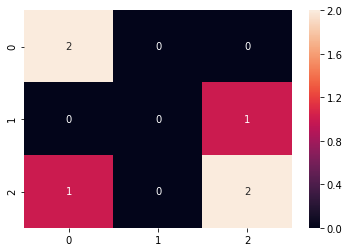

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

actual_values = [2, 0, 2, 2, 0, 1]
predictions = [0, 0, 2, 2, 0, 2]

conf_m=confusion_matrix(actual_values, predictions)

print (conf_m)
sns.heatmap(conf_m, annot=True)
plt.show();